# 04 - Gutenberg-Richter Analysis

This notebook analyzes the frequency-magnitude distribution of earthquakes using the Gutenberg-Richter law and estimates the b-value.

## The Gutenberg-Richter Law

$$\log_{10}(N) = a - bM$$

Where:
- N = Cumulative number of earthquakes ≥ magnitude M
- a = Activity level (seismicity rate)
- b = b-value (typically ~1.0, indicates relative frequency of large vs small earthquakes)

## Contents
1. Setup and Data Loading
2. Magnitude of Completeness (Mc)
3. b-value Estimation (MLE)
4. Bootstrap Confidence Intervals
5. Spatial Variation of b-value
6. Temporal Variation of b-value
7. Recurrence Interval Estimation

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from visualization import setup_style, create_turkey_basemap, plot_gutenberg_richter
from seismology import (
    magnitude_completeness_maxc, 
    gutenberg_richter_bvalue,
    bootstrap_bvalue,
    calculate_recurrence_interval
)

setup_style()

# Create output directory
OUTPUT_DIR = os.path.join(FIGURES_PATH, '04_gutenberg_richter')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

print(f"Loaded {len(eq_df):,} seismic events")
print(f"Magnitude range: {eq_df['magnitude'].min():.1f} - {eq_df['magnitude'].max():.1f}")

Loaded 524,952 seismic events
Magnitude range: 0.2 - 7.7


## 2. Magnitude of Completeness (Mc)

In [2]:
# Calculate magnitude of completeness using Maximum Curvature method
magnitudes = eq_df['magnitude'].values
mc = magnitude_completeness_maxc(magnitudes, bin_width=0.1)

print(f"Estimated Magnitude of Completeness (Mc): {mc:.1f}")
print(f"Events >= Mc: {(magnitudes >= mc).sum():,} ({(magnitudes >= mc).mean()*100:.1f}%)")

Estimated Magnitude of Completeness (Mc): 1.7
Events >= Mc: 316,943 (60.4%)


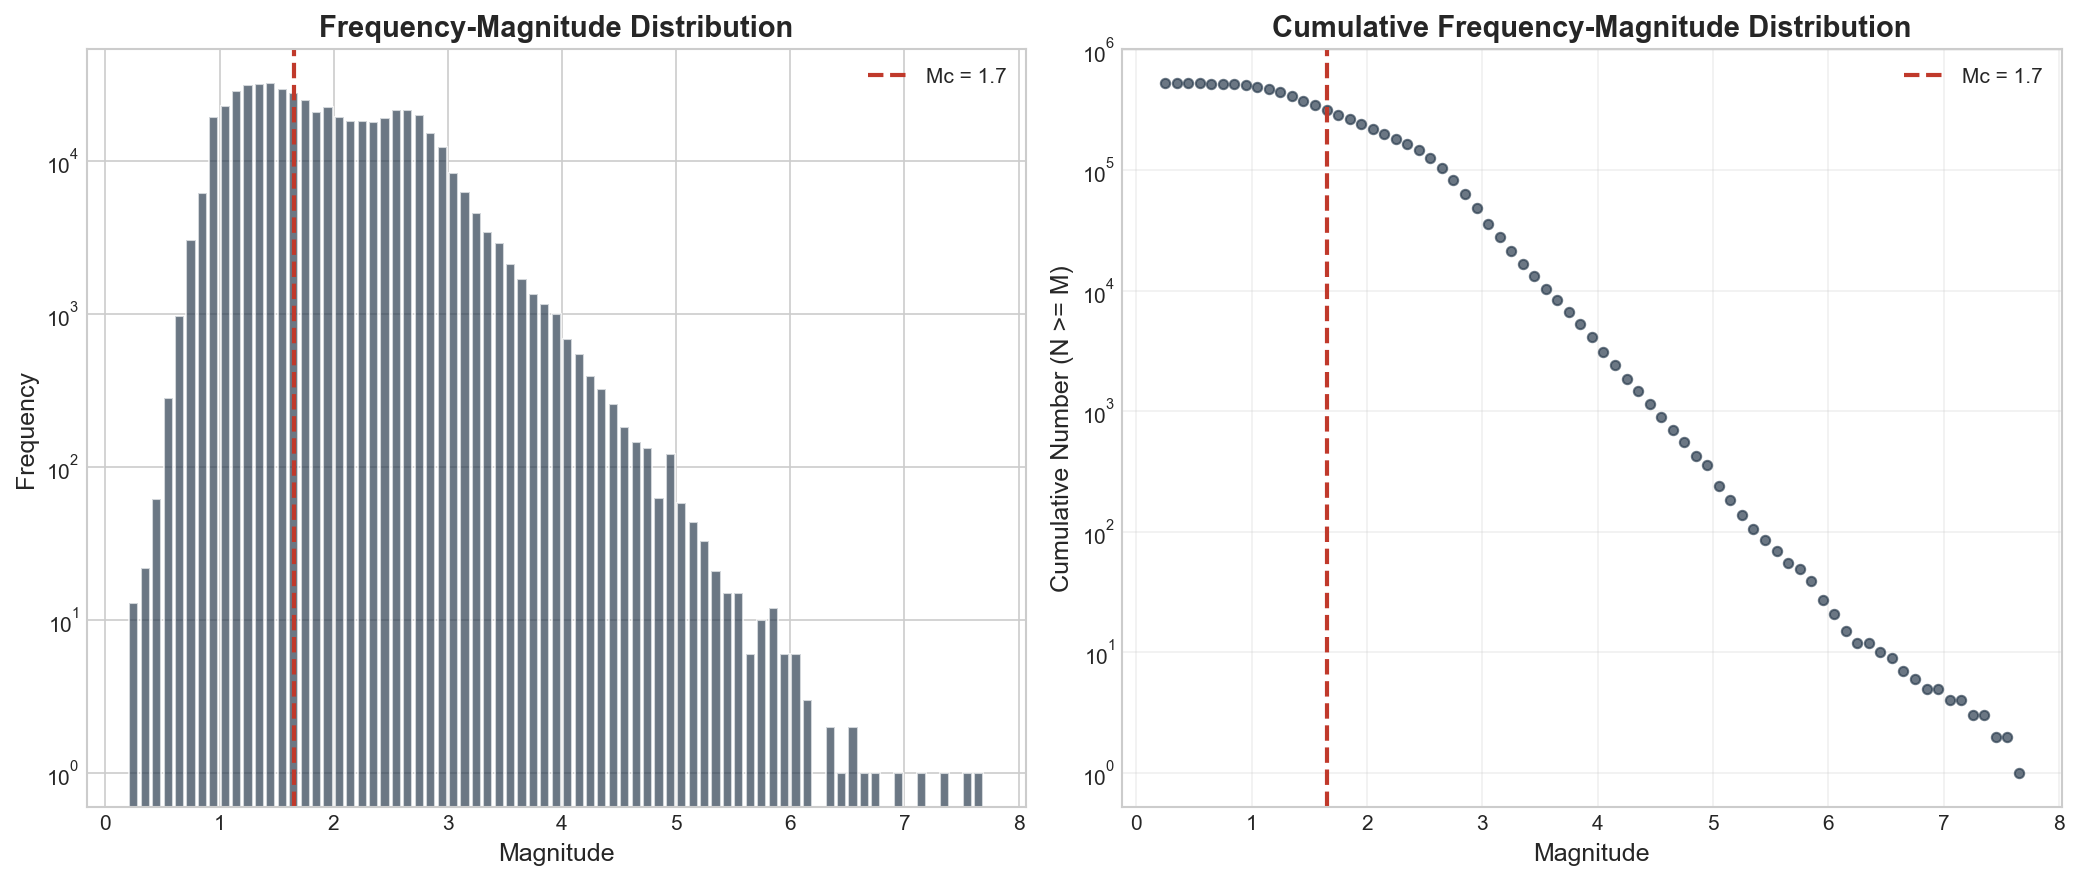

In [3]:
# Visualize frequency-magnitude distribution and Mc
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Non-cumulative distribution (to show Mc)
ax1 = axes[0]
bins = np.arange(magnitudes.min(), magnitudes.max() + 0.1, 0.1)
counts, bin_edges = np.histogram(magnitudes, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ax1.bar(bin_centers, counts, width=0.08, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.axvline(mc, color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mc = {mc:.1f}')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Frequency')
ax1.set_title('Frequency-Magnitude Distribution', fontweight='bold')
ax1.legend()
ax1.set_yscale('log')

# Cumulative distribution
ax2 = axes[1]
cum_counts = np.array([(magnitudes >= m).sum() for m in bin_centers])
ax2.scatter(bin_centers, cum_counts, c=COLORS['primary'], s=20, alpha=0.7)
ax2.axvline(mc, color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mc = {mc:.1f}')
ax2.set_xlabel('Magnitude')
ax2.set_ylabel('Cumulative Number (N >= M)')
ax2.set_title('Cumulative Frequency-Magnitude Distribution', fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'magnitude_completeness.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. b-value Estimation (MLE)

In [4]:
# Calculate b-value using Maximum Likelihood Estimation
b_result = gutenberg_richter_bvalue(magnitudes, mc, method='mle')

print("=" * 60)
print("GUTENBERG-RICHTER PARAMETERS")
print("=" * 60)
print(f"\nMagnitude of Completeness (Mc): {mc:.1f}")
print(f"b-value: {b_result['b']:.3f} ± {b_result['b_std']:.3f}")
print(f"a-value: {b_result['a']:.3f}")
print(f"Number of events (>= Mc): {b_result['n_events']:,}")
print(f"Method: {b_result['method'].upper()}")

GUTENBERG-RICHTER PARAMETERS

Magnitude of Completeness (Mc): 1.7
b-value: 0.525 ± 0.000
a-value: 6.368
Number of events (>= Mc): 316,943
Method: MLE


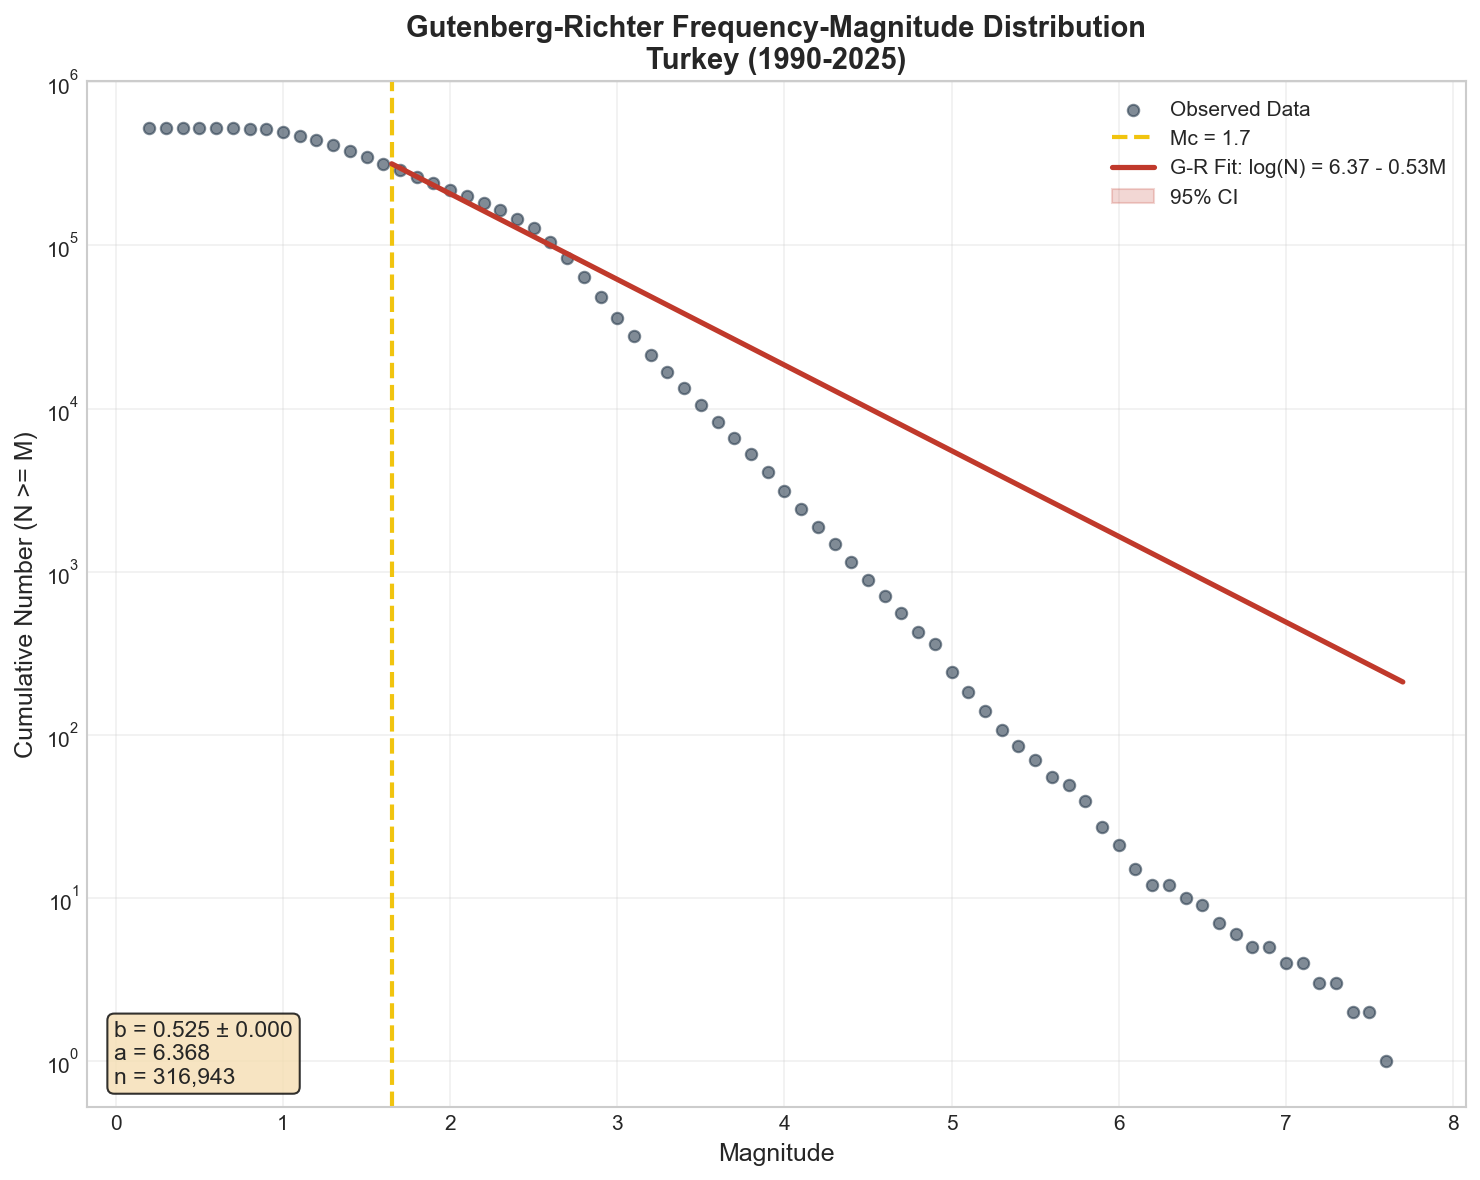

In [5]:
# Plot Gutenberg-Richter distribution with fitted line
fig, ax = plt.subplots(figsize=(10, 8))

# Observed data
mag_bins = np.arange(magnitudes.min(), magnitudes.max() + 0.1, 0.1)
cum_counts = np.array([(magnitudes >= m).sum() for m in mag_bins])

ax.scatter(mag_bins, cum_counts, c=COLORS['primary'], s=30, alpha=0.6, 
           label='Observed Data', zorder=3)

# Mc line
ax.axvline(mc, color=COLORS['warning'], linestyle='--', linewidth=2, 
           label=f'Mc = {mc:.1f}', zorder=2)

# Fitted G-R line
mag_fit = np.linspace(mc, magnitudes.max(), 50)
log_n_fit = b_result['a'] - b_result['b'] * mag_fit
n_fit = 10 ** log_n_fit

ax.plot(mag_fit, n_fit, color=COLORS['danger'], linewidth=2.5,
        label=f'G-R Fit: log(N) = {b_result["a"]:.2f} - {b_result["b"]:.2f}M', zorder=4)

# Confidence interval (approximate)
b_upper = b_result['b'] + 2 * b_result['b_std']
b_lower = b_result['b'] - 2 * b_result['b_std']
n_upper = 10 ** (b_result['a'] - b_lower * mag_fit)
n_lower = 10 ** (b_result['a'] - b_upper * mag_fit)
ax.fill_between(mag_fit, n_lower, n_upper, alpha=0.2, color=COLORS['danger'], label='95% CI')

ax.set_yscale('log')
ax.set_xlabel('Magnitude', fontsize=12)
ax.set_ylabel('Cumulative Number (N >= M)', fontsize=12)
ax.set_title('Gutenberg-Richter Frequency-Magnitude Distribution\nTurkey (1990-2025)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add text box with parameters
textstr = f'b = {b_result["b"]:.3f} ± {b_result["b_std"]:.3f}\na = {b_result["a"]:.3f}\nn = {b_result["n_events"]:,}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.02, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'gutenberg_richter_fit.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Bootstrap Confidence Intervals

In [6]:
# Bootstrap estimation for more robust confidence intervals
print("Running bootstrap estimation (1000 iterations)...")
bootstrap_result = bootstrap_bvalue(magnitudes, mc, n_iterations=1000, confidence=0.95)

print("\nBootstrap Results:")
print(f"  b-value mean: {bootstrap_result['b_mean']:.3f}")
print(f"  Standard deviation: {bootstrap_result['b_std']:.3f}")
print(f"  95% CI: [{bootstrap_result['b_lower']:.3f}, {bootstrap_result['b_upper']:.3f}]")

Running bootstrap estimation (1000 iterations)...



Bootstrap Results:
  b-value mean: 0.525
  Standard deviation: 0.001
  95% CI: [0.524, 0.527]


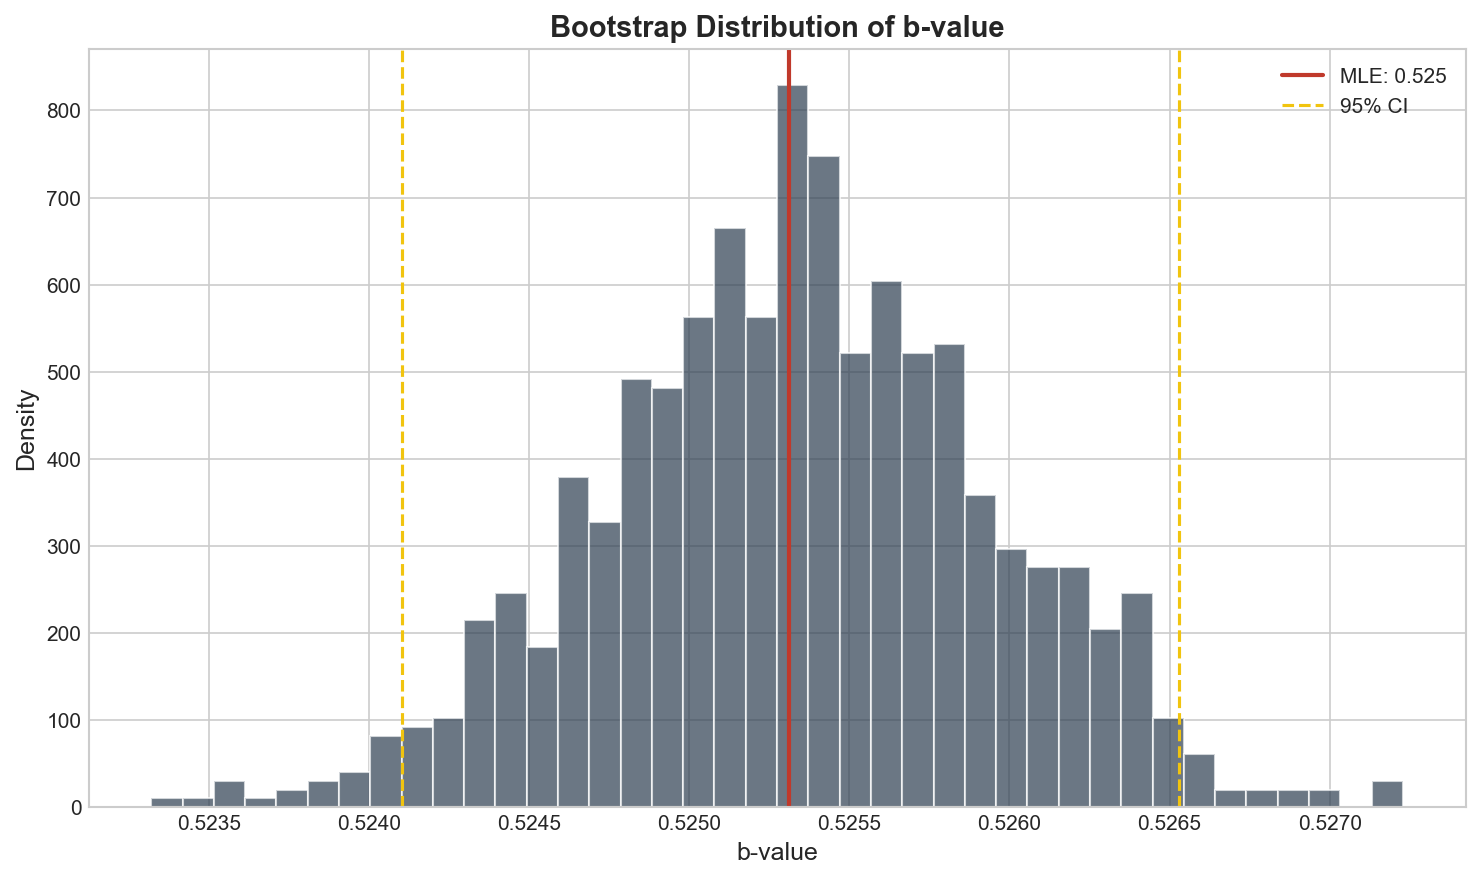

In [7]:
# Visualize bootstrap distribution
np.random.seed(42)
b_samples = []
mags_above_mc = magnitudes[magnitudes >= mc]

for _ in range(1000):
    sample = np.random.choice(mags_above_mc, size=len(mags_above_mc), replace=True)
    result = gutenberg_richter_bvalue(sample, mc, method='mle')
    if result:
        b_samples.append(result['b'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(b_samples, bins=40, color=COLORS['primary'], alpha=0.7, edgecolor='white', density=True)
ax.axvline(b_result['b'], color=COLORS['danger'], linewidth=2, label=f'MLE: {b_result["b"]:.3f}')
ax.axvline(bootstrap_result['b_lower'], color=COLORS['warning'], linestyle='--', 
           linewidth=1.5, label=f'95% CI')
ax.axvline(bootstrap_result['b_upper'], color=COLORS['warning'], linestyle='--', linewidth=1.5)

ax.set_xlabel('b-value')
ax.set_ylabel('Density')
ax.set_title('Bootstrap Distribution of b-value', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'bootstrap_bvalue.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Spatial Variation of b-value

In [8]:
# Calculate b-value for different regions
regions = {
    'Western Turkey': {'lon': (26, 32), 'lat': (36, 41)},
    'Central Turkey': {'lon': (32, 38), 'lat': (37, 41)},
    'Eastern Turkey': {'lon': (38, 45), 'lat': (36, 42)},
    'Marmara Region': {'lon': (26, 31), 'lat': (39.5, 41.5)},
    'Eastern Anatolia': {'lon': (38, 45), 'lat': (38, 42)}
}

regional_results = []

print("Regional b-values:")
print("-" * 60)

for region_name, bounds in regions.items():
    mask = (
        (eq_df['longitude'] >= bounds['lon'][0]) & 
        (eq_df['longitude'] <= bounds['lon'][1]) &
        (eq_df['latitude'] >= bounds['lat'][0]) & 
        (eq_df['latitude'] <= bounds['lat'][1])
    )
    region_mags = eq_df.loc[mask, 'magnitude'].values
    
    if len(region_mags) > 100:
        mc_region = magnitude_completeness_maxc(region_mags)
        result = gutenberg_richter_bvalue(region_mags, mc_region, method='mle')
        
        if result:
            regional_results.append({
                'Region': region_name,
                'n_events': result['n_events'],
                'Mc': mc_region,
                'b_value': result['b'],
                'b_std': result['b_std'],
                'a_value': result['a']
            })
            print(f"{region_name}: b = {result['b']:.3f} ± {result['b_std']:.3f} (n = {result['n_events']:,})")

regional_df = pd.DataFrame(regional_results)
regional_df

Regional b-values:
------------------------------------------------------------
Western Turkey: b = 0.542 ± 0.000 (n = 153,707)
Central Turkey: b = 0.544 ± 0.000 (n = 61,013)
Eastern Turkey: b = 0.463 ± 0.000 (n = 90,095)
Marmara Region: b = 1.061 ± 0.000 (n = 3,858)
Eastern Anatolia: b = 0.466 ± 0.000 (n = 80,608)


,Region,n_events,Mc,b_value,b_std,a_value
0,Western Turkey,153707,1.65,0.541721,0.000002,6.080534
1,Central Turkey,61013,1.65,0.544310,0.000006,5.683534
2,Eastern Turkey,90095,1.45,0.463291,0.000003,5.626473
3,Marmara Region,3858,2.95,1.060515,0.000273,6.714882
4,Eastern Anatolia,80608,1.45,0.465812,0.000004,5.581806


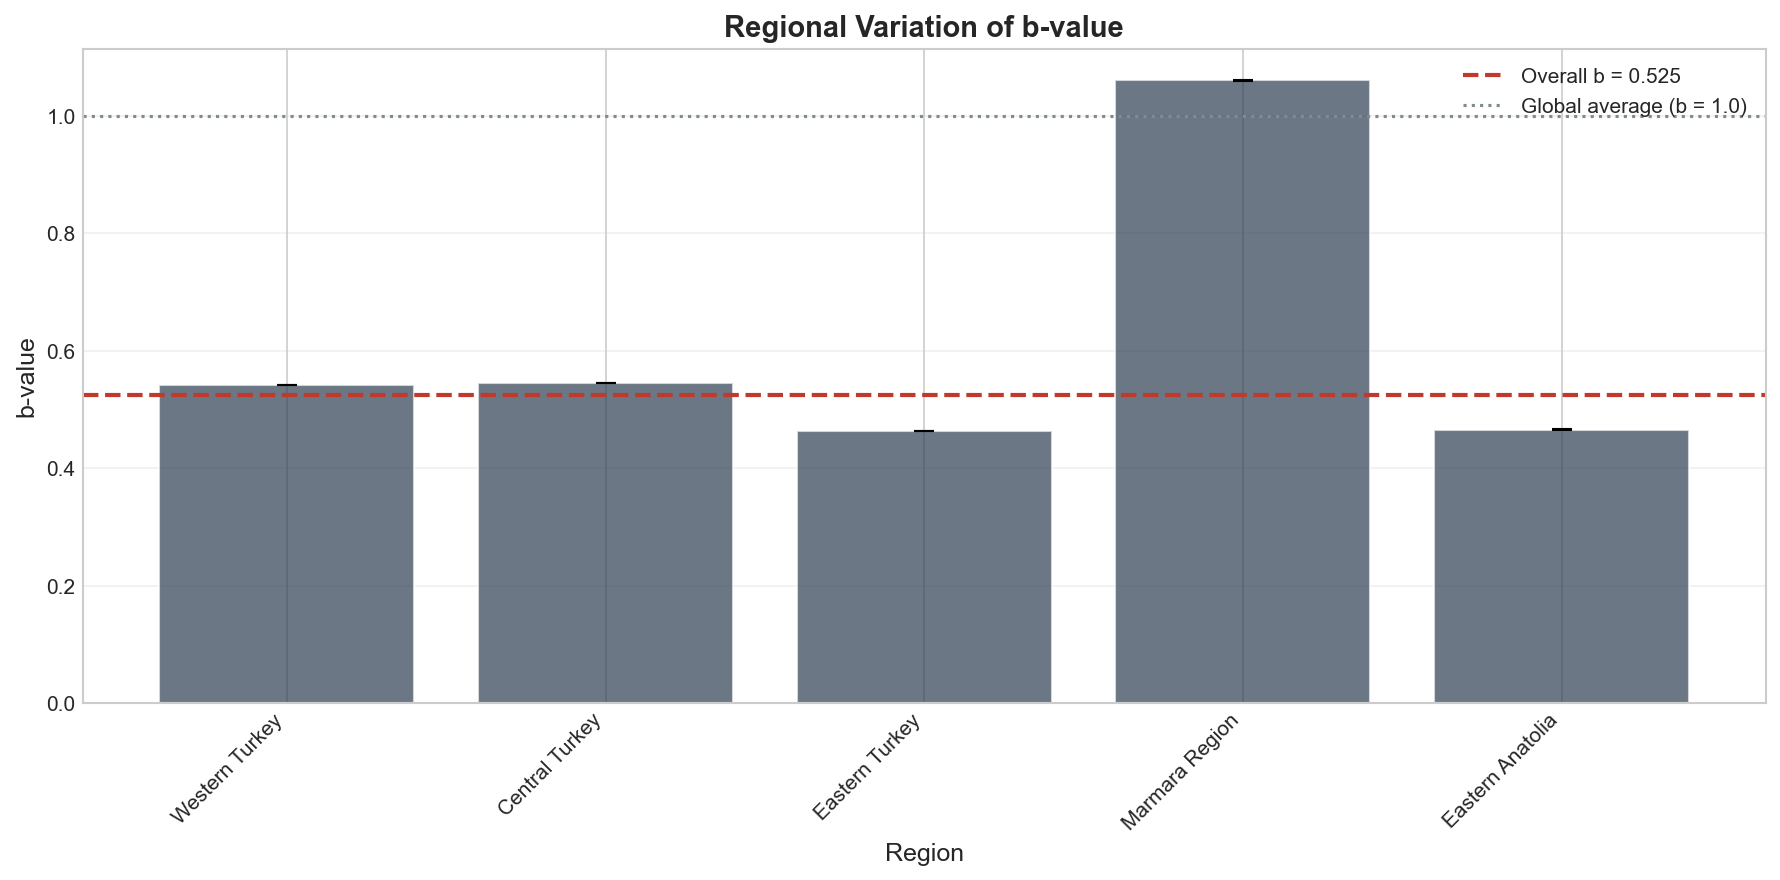

In [9]:
# Visualize regional b-values
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(regional_df))
ax.bar(x, regional_df['b_value'], yerr=regional_df['b_std'] * 2, 
       capsize=5, color=COLORS['primary'], alpha=0.7, edgecolor='white')

# Reference line for global b-value
ax.axhline(b_result['b'], color=COLORS['danger'], linestyle='--', 
           linewidth=2, label=f'Overall b = {b_result["b"]:.3f}')
ax.axhline(1.0, color=COLORS['secondary'], linestyle=':', 
           linewidth=1.5, label='Global average (b = 1.0)')

ax.set_xticks(x)
ax.set_xticklabels(regional_df['Region'], rotation=45, ha='right')
ax.set_xlabel('Region')
ax.set_ylabel('b-value')
ax.set_title('Regional Variation of b-value', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'regional_bvalue.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Temporal Variation of b-value

In [10]:
# Calculate b-value for each 5-year period
periods = [(1990, 1995), (1995, 2000), (2000, 2005), (2005, 2010), 
           (2010, 2015), (2015, 2020), (2020, 2026)]

temporal_results = []

for start, end in periods:
    mask = (eq_df['year'] >= start) & (eq_df['year'] < end)
    period_mags = eq_df.loc[mask, 'magnitude'].values
    
    if len(period_mags) > 100:
        mc_period = magnitude_completeness_maxc(period_mags)
        result = gutenberg_richter_bvalue(period_mags, mc_period, method='mle')
        
        if result:
            temporal_results.append({
                'Period': f'{start}-{end-1}',
                'Start': start,
                'n_events': result['n_events'],
                'Mc': mc_period,
                'b_value': result['b'],
                'b_std': result['b_std']
            })

temporal_df = pd.DataFrame(temporal_results)
temporal_df

,Period,Start,n_events,Mc,b_value,b_std
0,1990-1994,1990,638,3.15,0.613687,0.000751
1,1995-1999,1995,1474,3.15,0.826213,0.000466
2,2000-2004,2000,5710,2.85,0.983783,0.000148
3,2005-2009,2005,14218,2.95,1.396381,0.000088
4,2010-2014,2010,23280,2.75,1.193725,0.000048
5,2015-2019,2015,73794,1.45,0.750284,0.000009
6,2020-2025,2020,122995,1.55,0.676416,0.000005


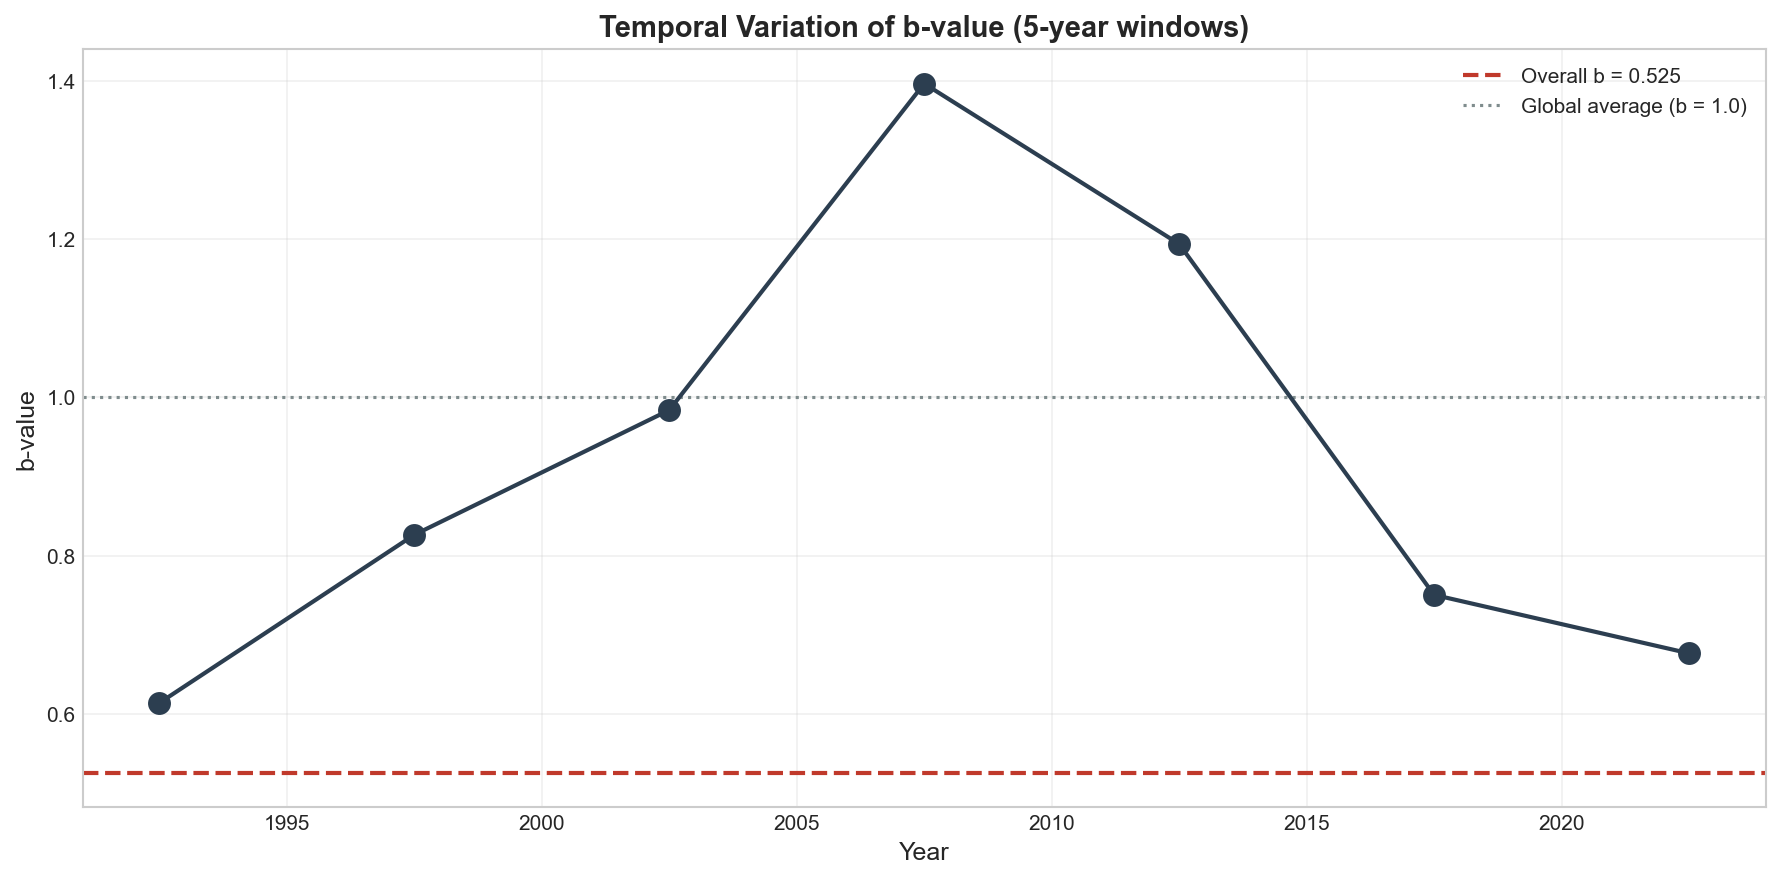

In [11]:
# Plot temporal variation
fig, ax = plt.subplots(figsize=(12, 6))

ax.errorbar(temporal_df['Start'] + 2.5, temporal_df['b_value'], 
            yerr=temporal_df['b_std'] * 2, fmt='o-', 
            color=COLORS['primary'], markersize=10, capsize=5, linewidth=2)

# Reference lines
ax.axhline(b_result['b'], color=COLORS['danger'], linestyle='--', 
           linewidth=2, label=f'Overall b = {b_result["b"]:.3f}')
ax.axhline(1.0, color=COLORS['secondary'], linestyle=':', 
           linewidth=1.5, label='Global average (b = 1.0)')

ax.set_xlabel('Year')
ax.set_ylabel('b-value')
ax.set_title('Temporal Variation of b-value (5-year windows)', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_bvalue.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Recurrence Interval Estimation

In [12]:
# Calculate annual a-value
years_of_data = (eq_df['date'].max() - eq_df['date'].min()).days / 365.25
n_annual = b_result['n_events'] / years_of_data
a_annual = np.log10(n_annual) + b_result['b'] * mc

print(f"Years of data: {years_of_data:.1f}")
print(f"Annual rate (>= Mc): {n_annual:.1f} events/year")
print(f"Annual a-value: {a_annual:.3f}")

Years of data: 35.9
Annual rate (>= Mc): 8833.5 events/year
Annual a-value: 4.813


In [13]:
# Calculate recurrence intervals for different magnitudes
target_magnitudes = np.arange(4.0, 8.5, 0.5)
recurrence_intervals = calculate_recurrence_interval(b_result['b'], a_annual, target_magnitudes)

recurrence_df = pd.DataFrame({
    'Magnitude': target_magnitudes,
    'Annual_Rate': 10 ** (a_annual - b_result['b'] * target_magnitudes),
    'Recurrence_Years': recurrence_intervals
})

print("\nRecurrence Intervals:")
print("-" * 50)
for _, row in recurrence_df.iterrows():
    if row['Recurrence_Years'] < 1:
        print(f"M >= {row['Magnitude']:.1f}: {row['Annual_Rate']:.1f} events/year")
    else:
        print(f"M >= {row['Magnitude']:.1f}: Every {row['Recurrence_Years']:.1f} years")

recurrence_df


Recurrence Intervals:
--------------------------------------------------
M >= 4.0: 514.8 events/year
M >= 4.5: 281.2 events/year
M >= 5.0: 153.6 events/year
M >= 5.5: 83.9 events/year
M >= 6.0: 45.8 events/year
M >= 6.5: 25.0 events/year
M >= 7.0: 13.7 events/year
M >= 7.5: 7.5 events/year
M >= 8.0: 4.1 events/year


,Magnitude,Annual_Rate,Recurrence_Years
0,4.0,514.811768,0.001942
1,4.5,281.184833,0.003556
2,5.0,153.580231,0.006511
3,5.5,83.883925,0.011921
4,6.0,45.816527,0.021826
5,6.5,25.024511,0.039961
6,7.0,13.668127,0.073163
7,7.5,7.465389,0.133951
8,8.0,4.077518,0.245247


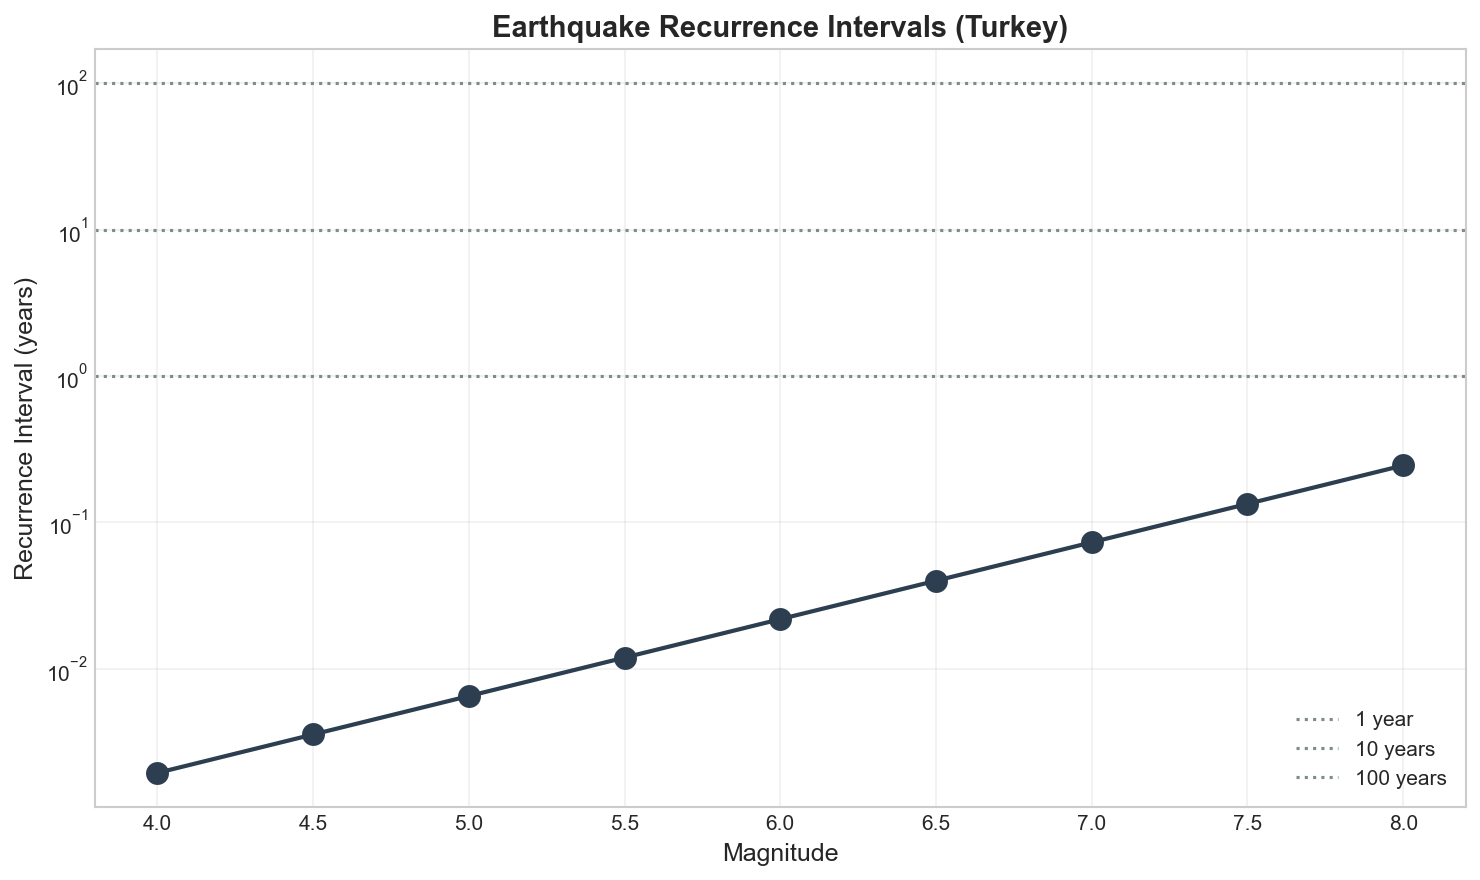

In [14]:
# Visualize recurrence intervals
fig, ax = plt.subplots(figsize=(10, 6))

ax.semilogy(recurrence_df['Magnitude'], recurrence_df['Recurrence_Years'], 
            'o-', color=COLORS['primary'], markersize=10, linewidth=2)

# Add reference lines
ax.axhline(1, color=COLORS['secondary'], linestyle=':', label='1 year')
ax.axhline(10, color=COLORS['secondary'], linestyle=':', label='10 years')
ax.axhline(100, color=COLORS['secondary'], linestyle=':', label='100 years')

ax.set_xlabel('Magnitude')
ax.set_ylabel('Recurrence Interval (years)')
ax.set_title('Earthquake Recurrence Intervals (Turkey)', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'recurrence_intervals.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. Export Results

In [15]:
# Save results
results_summary = {
    'Parameter': ['Mc', 'b-value', 'b-value (std)', 'a-value', 'a-value (annual)', 
                  'N events (>= Mc)', 'Years of data'],
    'Value': [mc, b_result['b'], b_result['b_std'], b_result['a'], a_annual,
              b_result['n_events'], years_of_data]
}

results_df = pd.DataFrame(results_summary)
results_df.to_csv(os.path.join(TABLES_PATH, 'gutenberg_richter_results.csv'), index=False)
print(f"Results saved to: {os.path.join(TABLES_PATH, 'gutenberg_richter_results.csv')}")

# Save regional results
regional_df.to_csv(os.path.join(TABLES_PATH, 'regional_bvalues.csv'), index=False)
print(f"Regional results saved to: {os.path.join(TABLES_PATH, 'regional_bvalues.csv')}")

# Save recurrence intervals
recurrence_df.to_csv(os.path.join(TABLES_PATH, 'recurrence_intervals.csv'), index=False)
print(f"Recurrence intervals saved to: {os.path.join(TABLES_PATH, 'recurrence_intervals.csv')}")

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/gutenberg_richter_results.csv
Regional results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/regional_bvalues.csv
Recurrence intervals saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/recurrence_intervals.csv


In [16]:
print("\n" + "=" * 60)
print("GUTENBERG-RICHTER ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nKey Findings:")
print(f"  - Magnitude of Completeness (Mc): {mc:.1f}")
print(f"  - b-value: {b_result['b']:.3f} ± {b_result['b_std']:.3f}")
print(f"  - M >= 7.0 earthquake expected every {recurrence_df[recurrence_df['Magnitude'] == 7.0]['Recurrence_Years'].values[0]:.1f} years")
print(f"\nFigures saved to: {OUTPUT_DIR}")


GUTENBERG-RICHTER ANALYSIS COMPLETE

Key Findings:
  - Magnitude of Completeness (Mc): 1.7
  - b-value: 0.525 ± 0.000
  - M >= 7.0 earthquake expected every 0.1 years

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/04_gutenberg_richter
